In [1]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import pandas as pd

In [2]:
seed = 29
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Define data path
DATA_PATH = "/Users/prashanti.nilayam/Desktop/temp/"
prev_value_map = {}


In [3]:
train_y_df = pd.read_csv(DATA_PATH + 'train_listfile.csv') 
train_files = train_y_df["stay"].unique().tolist()
val_y_df = pd.read_csv(DATA_PATH + 'train_listfile.csv') 
val_files = val_y_df["stay"].unique().tolist()

In [4]:
len(train_y_df["stay"].unique().tolist())

29168

In [5]:
np.random.choice(train_y_df["stay"].unique().tolist(), 5000, replace=False)

array(['3613_episode1_timeseries.csv', '10205_episode1_timeseries.csv',
       '3319_episode1_timeseries.csv', ...,
       '11346_episode5_timeseries.csv', '60988_episode1_timeseries.csv',
       '51485_episode1_timeseries.csv'], dtype='<U30')

In [6]:
default_value_map = {"Capillary refill rate": 0.0,
    "Diastolic blood pressure": 59.0,
    "Fraction inspired oxygen": 0.21,
    "Glascow coma scale eye opening": 4,
    "Glascow coma scale motor response": 6,
    "Glascow coma scale total": 15,
    "Glascow coma scale verbal response": 5,
    "Glucose": 128.0,
    "Heart Rate": 86,
    "Height": 170.0,
    "Mean blood pressure": 77.0,
    "Oxygen saturation": 98.0,
    "Respiratory rate": 19,
    "Systolic blood pressure": 118.0,
    "Temperature": 36.6,
    "Weight": 81.0,
    "pH": 7.4}

In [7]:
replacement_map = {
    "Glascow coma scale eye opening":{
        "1 No Response" : 1,
        "No Response" : 1,
        "2 To pain" : 2,
        "To Pain" : 2,
        "3 To speech" : 3,
        "To Speech" : 3,
        "4 Spontaneously" : 4,
        "Spontaneously" : 4,
        "None" : 5
    },
    "Glascow coma scale motor response":{
        "1 No Response": 1,
        "2 Abnorm extensn" : 2,
        "Abnormal extension": 2,
        "3 Abnorm flexion": 3,
        "Abnormal Flexion": 3,
        "4 Flex-withdraws" : 4,
        "Flex-withdraws": 4,
        "5 Localizes Pain": 5,
        "Localizes Pain": 5,
        "6 Obeys Commands": 6,
        "Obeys Commands": 6,
        "No response" : 7,
    },
    "Glascow coma scale verbal response":{
        "1 No Response" :1,
        "No Response":1,
        "2 Incomp sounds": 2,
        "Incomprehensible sounds":2,
        "3 Inapprop words":3,
        "Inappropriate Words":3,
        "4 Confused":4,
        "Confused":4,
        "5 Oriented":5,
        "Oriented":5,
        "No Response-ETT":6,
        "1.0 ET/Trach":7
    }
}

In [8]:
def to_np(elem):
    return np.concatenate([np.array(i) for i in elem])

In [9]:
def cleanup(episode_df):
    episode_df["Glascow coma scale eye opening"] = episode_df["Glascow coma scale eye opening"].apply(lambda x: replacement_map["Glascow coma scale eye opening"][x] if x in replacement_map["Glascow coma scale eye opening"] else x)
    episode_df["Glascow coma scale motor response"] = episode_df["Glascow coma scale motor response"].apply(lambda x: replacement_map["Glascow coma scale motor response"][x] if x in replacement_map["Glascow coma scale motor response"] else x)
    episode_df["Glascow coma scale verbal response"] = episode_df["Glascow coma scale verbal response"].apply(lambda x: replacement_map["Glascow coma scale verbal response"][x] if x in replacement_map["Glascow coma scale verbal response"] else x)


In [10]:
def process_capillary_refill_rate(person_id, value, colname):
    if value is not None and not np.isnan(value):
        prev_value_map[person_id][colname] = value
        return value
    if person_id in prev_value_map and colname in prev_value_map[person_id] and prev_value_map[person_id][colname] is not None:
        prev = prev_value_map[person_id][colname]
    else:
        prev = default_value_map[colname]
    return prev

In [11]:
def fill_missing_values(pateint_id, episode_df):
     prev_value_map[pateint_id] = {}
     episode_df["Capillary refill rate"] = episode_df["Capillary refill rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Capillary refill rate"))
     episode_df["Diastolic blood pressure"] = episode_df["Diastolic blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Diastolic blood pressure"))
     episode_df["Fraction inspired oxygen"] = episode_df["Fraction inspired oxygen"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Fraction inspired oxygen"))
     episode_df["Glascow coma scale eye opening"] = episode_df["Glascow coma scale eye opening"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale eye opening"))
     episode_df["Glascow coma scale motor response"] = episode_df["Glascow coma scale motor response"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale motor response"))
     episode_df["Glascow coma scale total"] = episode_df["Glascow coma scale total"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glascow coma scale total"))
     episode_df["Glascow coma scale verbal response"] = episode_df["Glascow coma scale verbal response"].apply(lambda x: process_capillary_refill_rate(pateint_id,  x, "Glascow coma scale verbal response"))
     episode_df["Glucose"] = episode_df["Glucose"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Glucose"))
     episode_df["Heart Rate"] = episode_df["Heart Rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Heart Rate"))
     episode_df["Mean blood pressure"] = episode_df["Mean blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Mean blood pressure"))
     episode_df["Height"] = episode_df["Height"].apply(lambda x: process_capillary_refill_rate(pateint_id,x, "Height"))
     episode_df["Oxygen saturation"] = episode_df["Oxygen saturation"].apply(lambda x: process_capillary_refill_rate(pateint_id,  x, "Oxygen saturation"))
     episode_df["Respiratory rate"] = episode_df["Respiratory rate"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Respiratory rate"))
     episode_df["Systolic blood pressure"] = episode_df["Systolic blood pressure"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Systolic blood pressure"))
     episode_df["Temperature"] = episode_df["Temperature"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Temperature"))
     episode_df["Weight"] = episode_df["Weight"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "Weight"))
     episode_df["pH"] = episode_df["pH"].apply(lambda x: process_capillary_refill_rate(pateint_id, x, "pH"))
     del prev_value_map[pateint_id]

In [12]:
def get_window_indices(data_len, window_len = 4):
    i = 0
    indices = []
    while i <= data_len-window_len:
        indices.append([i+j for j in range(window_len)])
        i +=1
    return indices

In [13]:
def get_one_hot_encoding(val, dim):
    encoding = [0 for i in range (dim)]
    encoding[val-1] = 1
    return encoding

In [14]:
get_window_indices(7,5)

[[0, 1, 2, 3, 4], [1, 2, 3, 4, 5], [2, 3, 4, 5, 6]]

In [15]:
def preprocess(path):
    x_path = DATA_PATH +'/'+path+'/'
    X = torch.empty(0,34,8)
    Y = torch.empty(0,)
    y_df = pd.read_csv(DATA_PATH + "train" +'_listfile.csv') 
    data_files = os.listdir(x_path)
    print(data_files)
    for data_file in data_files:
        print(data_file)
        if data_file.endswith(".csv"):
            episode_df = pd.read_csv(x_path + data_file)
            cleanup(episode_df)
            fill_missing_values(data_file, episode_df)
            episode_df["H_IDX"] = episode_df.Hours.apply(np.floor).astype('int32')
            episode_df = episode_df.groupby(by = "H_IDX").agg("last")
            gcser = pd.DataFrame(episode_df["Glascow coma scale eye opening"].astype('int32').apply(get_one_hot_encoding, args=(5,)).to_list())
            gcsmr = pd.DataFrame(episode_df["Glascow coma scale motor response"].astype('int32').apply(get_one_hot_encoding, args=(7,)).to_list())
            gcsvr = pd.DataFrame(episode_df["Glascow coma scale verbal response"].astype('int32').apply(get_one_hot_encoding, args=(7,)).to_list()) 
            episode_df = pd.concat((episode_df, gcser, gcsmr, gcsvr), axis=1)
            episode_df = episode_df.drop(["Glascow coma scale eye opening", "Glascow coma scale motor response", "Glascow coma scale verbal response"], axis=1)
            #episode_df = episode_df[episode_df.Hours>=5].reset_index(drop = True)
            temp_y = y_df[y_df.stay == data_file].sort_values(by = "period_length").reset_index(drop = True)
            temp_y = temp_y[["period_length", "y_true"]].set_index("period_length")
            episode_df = episode_df.join(temp_y, how = "inner").reset_index(drop = True)
            episode_df = episode_df.dropna().reset_index(drop = True)
            if(len(episode_df) >0):
                indices = get_window_indices(len(episode_df), window_len=8)
                windows = []
                y_values = []
                for idx in indices:
                    window = episode_df.loc[idx]
                    y_values.append(window.loc[idx[-1]].y_true)
                    windows.append(window.drop("y_true", axis=1).transpose().values.astype(np.float32))
                t_windows = torch.tensor(windows)
                t_y_values = torch.tensor(y_values)
                X = torch.cat((X, t_windows), 0)
                Y = torch.cat((Y, t_y_values), 0)
    return (X, Y)

In [16]:
X_train, Y_train = preprocess('train')

['.DS_Store', '10010_episode1_timeseries.csv', '10003_episode1_timeseries.csv', '10014_episode1_timeseries.csv', '10007_episode1_timeseries.csv', '1000_episode1_timeseries.csv', '10022_episode1_timeseries.csv']
.DS_Store
10010_episode1_timeseries.csv
10003_episode1_timeseries.csv
10014_episode1_timeseries.csv
10007_episode1_timeseries.csv
1000_episode1_timeseries.csv
10022_episode1_timeseries.csv


In [17]:
X_train.shape

torch.Size([875, 34, 8])

In [18]:
from torch.utils.data import Dataset

class EpisodeDataset(Dataset):
    
    def __init__(self, obs, los):
        self.x = obs
        self.y = los
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
        
X_train, Y_train = preprocess('train')
train_dataset = EpisodeDataset(X_train, Y_train)
X_val, Y_val = preprocess('val')
val_dataset = EpisodeDataset(X_val, Y_val)

['.DS_Store', '10010_episode1_timeseries.csv', '10003_episode1_timeseries.csv', '10014_episode1_timeseries.csv', '10007_episode1_timeseries.csv', '1000_episode1_timeseries.csv', '10022_episode1_timeseries.csv']
.DS_Store
10010_episode1_timeseries.csv
10003_episode1_timeseries.csv
10014_episode1_timeseries.csv
10007_episode1_timeseries.csv
1000_episode1_timeseries.csv
10022_episode1_timeseries.csv
['10021_episode1_timeseries.csv', '10017_episode1_timeseries.csv', '10013_episode1_timeseries.csv']
10021_episode1_timeseries.csv
10017_episode1_timeseries.csv
10013_episode1_timeseries.csv


In [19]:
Y_train.shape

torch.Size([875])

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)                              
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=32, shuffle=False)                                         

In [21]:
for data in train_dataset:
    print(data[0], data[1])
    break

tensor([[  5.7300,   6.6133,   7.6133,   8.6133,   9.6133,  10.6133,  11.6133,
          12.6133],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000],
        [ 72.0000,  72.0000,  54.0000,  55.0000,  56.0000,  51.0000,  64.0000,
          61.0000],
        [  0.2100,   0.2100,   0.2100,   0.2100,   0.2100,   0.2100,   0.2100,
           0.2100],
        [ 15.0000,  15.0000,  15.0000,  15.0000,  15.0000,  15.0000,  15.0000,
          15.0000],
        [ 93.0000,  93.0000,  93.0000,  93.0000,  93.0000,  93.0000,  93.0000,
          93.0000],
        [ 78.0000,  72.0000,  84.0000,  67.0000,  68.0000,  68.0000,  66.0000,
          66.0000],
        [170.0000, 170.0000, 170.0000, 170.0000, 170.0000, 170.0000, 170.0000,
         170.0000],
        [ 91.0000,  91.0000,  72.0000,  73.0000,  75.0000,  69.0000,  86.0000,
          80.0000],
        [ 96.0000,  95.0000,  97.0000,  96.0000,  95.0000,  96.0000,  94.0000,
          96.0000],
        [ 

In [22]:

class EpisiodeCNN(nn.Module):
    def __init__(self):
        super(EpisiodeCNN, self).__init__()
        #input shape 34 * 8
        #output shape 16 * 8
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride = 1)
        #input shape 16 * 8
        #output shape 32 * 8
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride = 1)
        #input shape 32 * 8
        #output shape 16 * 4
        self.pool1 = nn.MaxPool2d(2,2)
        #input shape 16 * 4
        #output shape 32 * 4
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride = 1)
        self.fc1 = nn.Linear(64*17*4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        #input is of shape (batch_size=32, 3, 224, 224) if you did the dataloader right
        x = x.unsqueeze(1)
        #print(x.shape)
        x = F.leaky_relu(self.conv1(x))
        #print(x.shape)
        x = F.leaky_relu(self.conv2(x))
        x = self.dropout(x)
        #print(x.shape)
        x = self.pool1(x)
        #print(x.shape)
        x = F.leaky_relu(self.conv3(x))
        #print(x.shape)
        x = x.view(-1, 64*17*4)
        x = F.leaky_relu(self.fc1(x))
        #x = self.dropout(x)
        #print(x.shape)
        x = F.leaky_relu(self.fc2(x))
        #print(x.shape)
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [23]:
model = EpisiodeCNN()
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate )

In [24]:
from sklearn.metrics import mean_squared_error
def eval_model(model, val_loader):
    model.eval()
    all_y_true = torch.DoubleTensor()
    all_y_pred = torch.DoubleTensor()
    for x, y in val_loader:
        y_hat = model(x)
        all_y_true = torch.cat((all_y_true, y.to('cpu')), dim=0)
        all_y_pred = torch.cat((all_y_pred,  y_hat.to('cpu')), dim=0)
    mse= mean_squared_error(all_y_true.detach().numpy(), all_y_pred.detach().numpy())
    print(f"mse: {mse:.3f}")
    return mse

In [25]:
import statistics
def train(model, train_loader, n_epochs):
    train_losses = []
    for epoch in range(n_epochs):
        loss_per_epoch = []
        model.train()
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            #print(x.shape)
            y_hat = model(x)
            #print(y_hat.shape)
            y_hat = y_hat.view(y_hat.shape[0]).double()
            #print(y_hat.shape)
            #print(y_hat)
            #print(y.shape)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loss_per_epoch.append(train_loss)
            #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
        #eval_model(model, val_loader)
        epoch_loss = statistics.mean(loss_per_epoch)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, epoch_loss))
        train_losses.append(epoch_loss)
    return train_losses

    
# number of epochs to train the model
n_epochs = 250
train_losses = train(model, train_loader, n_epochs)

Epoch: 1 	Training Loss: 2150277.334287
Epoch: 2 	Training Loss: 764939.968815
Epoch: 3 	Training Loss: 507421.219265
Epoch: 4 	Training Loss: 475987.468361
Epoch: 5 	Training Loss: 423478.490545
Epoch: 6 	Training Loss: 314897.961514
Epoch: 7 	Training Loss: 219455.513979
Epoch: 8 	Training Loss: 185753.628079
Epoch: 9 	Training Loss: 150475.206170
Epoch: 10 	Training Loss: 130410.811423
Epoch: 11 	Training Loss: 155721.050786
Epoch: 12 	Training Loss: 127822.850456
Epoch: 13 	Training Loss: 121755.134223
Epoch: 14 	Training Loss: 86030.881937
Epoch: 15 	Training Loss: 119589.485592
Epoch: 16 	Training Loss: 89326.069376
Epoch: 17 	Training Loss: 124917.033838
Epoch: 18 	Training Loss: 67788.463183
Epoch: 19 	Training Loss: 108739.161289
Epoch: 20 	Training Loss: 60185.408717
Epoch: 21 	Training Loss: 38194.379529
Epoch: 22 	Training Loss: 120542.745413
Epoch: 23 	Training Loss: 88554.842197
Epoch: 24 	Training Loss: 79453.986929
Epoch: 25 	Training Loss: 64124.056248
Epoch: 26 	Train

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
len(train_losses)

250

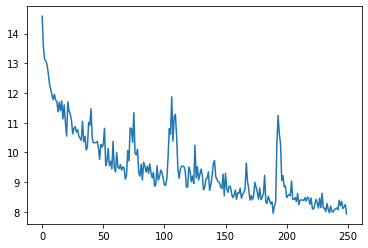

In [31]:
from math import log
train_losses = [log(y) for y in train_losses]
plt.plot(train_losses)
plt.show()

In [28]:
torch.save(model.state_dict(), DATA_PATH+"/model.pt")

In [29]:
model_loaded = EpisiodeCNN()
model_loaded.load_state_dict(torch.load(DATA_PATH+"/model.pt"))
eval_model(model_loaded, train_loader)

mse: 33476.029


33476.02936491705

In [26]:
1e-5

1e-05

In [42]:
train_losses

9095425988,
 2639457.4945351672,
 2702909.867290808,
 2765846.5763313705,
 2825921.281615666,
 2892385.8867543237,
 2980509.3284644224,
 3066625.2888902924,
 3153964.501665188,
 3235861.2848582035,
 3301567.7690591435,
 3341766.9066072656,
 69740.18382003013,
 154231.3854095592,
 213099.38036971565,
 296636.1944108474,
 351294.99517798,
 381471.71038330795,
 427194.51140209497,
 477170.0591822034,
 551857.5058442173,
 610435.0812980408,
 653138.685573638,
 699776.1636301999,
 744613.687674737,
 790935.0845149569,
 812481.869868954,
 824342.5979047051,
 893931.7219658341,
 945837.6909438869,
 995601.5692484805,
 1022276.3179598916,
 1043502.8854712368,
 1094973.1012866853,
 1165087.0827149346,
 1192550.1860823175,
 1204271.6397354153,
 1232060.0853277827,
 1277971.8797324894,
 1291835.8698726883,
 5089.925429874068,
 61285.22026963374,
 96438.28001381995,
 154557.58217138407,
 177884.1099879381,
 221990.63159901733,
 254834.32360879533,
 270169.6273294237,
 298897.12455407943,
 365466.4